# T81-558: Applications of Deep Neural Networks
**Module 6: Backpropagation.**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 6.1: Backpropagation Introduction](https://www.youtube.com/watch?v=Oe0-hX4KSZQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=18)
* [Part 6.2: Inside Backpropagation](https://www.youtube.com/watch?v=GDlI-3O5r6I&index=19&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.3: ADAM Update Rule](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

Weekly video update:

* [Weekly Update #6, Feb 18, 2018](https://www.youtube.com/watch?v=vD2BrT4v_G0)

# Helpful Functions

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Classic Backpropagation
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $

This process is repeated for every iteration($t$).  How the weight change is calculated depends on the training algorithm.  Classic backpropagation simply calculates a gradient ($\nabla$, nabla) for every weight in the neural network with respect to the error function ($J$) of the neural network.  The gradient is scaled by a learning rate ($\eta$, eta).

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) $

The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.

Gradients:

![Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv.png "Derivative")

The following link, from the book, shows how a simple [neural network is trained with backpropagation](http://www.heatonresearch.com/aifh/vol3/).

# Momentum Backpropagation

Momentum adds another term to the calculation of $v_t$:

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) + \lambda v_{t-1} $

Like the learning rate, momentum adds another training parameter that scales the effect of momentum.  Momentum backpropagation has two training parameters: learning rate ($\eta$, eta) and momentum ($\lambda$, lambda).  Momentum simply adds the scaled value of the previous weight change amount ($v_{t-1}$) to the current weight change amount($v_t$).

This has the effect of adding additional force behind a direction a weight was moving.  This might allow the weight to escape a local minima:

![Momentum](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_momentum.png "Momentum")

A very common value for momentum is 0.9.


# Batch and Online Backpropagation

How often should the weights of a neural network be updated?  Gradients can be calculated for a training set element.  These gradients can also be summed together into batches and the weights updated once per batch.

* **Online Training** - Update the weights based on gradients calculated from a single training set element.
* **Batch Training** - Update the weights based on the sum of the gradients over all training set elements.
* **Batch Size** - Update the weights based on the sum of some batch size of training set elements.
* **Mini-Batch Training** - The same as batch size, but with a very small batch size.  Mini-batches are very popular and they are often in the 32-64 element range.

Because the batch size is smaller than the complete training set size, it may take several batches to make it completely through the training set.  

* **Step/Iteration** - The number of batches that were processed.
* **Epoch** - The number of times the complete training set was processed.


# Stochastic Gradient Descent

Stochastic gradient descent (SGD) is currently one of the most popular neural network training algorithms.  It works very similarly to Batch/Mini-Batch training, except that the batches are made up of a random set of training elements.

This leads to a very irregular convergence in error during training:

![SGD Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_sgd_error.png "SGD Error")
[Image from Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Because the neural network is trained on a random sample of the complete training set each time, the error does not make a smooth transition downward.  However, the error usually does go down.

Advantages to SGD include:

* Computationally efficient.  Even with a very large training set, each training step can be relatively fast.
* Decreases overfitting by focusing on only a portion of the training set each step.


# Other Techniques

One problem with simple backpropagation training algorithms is that they are highly sensative to learning rate and momentum.  This is difficult because:

* Learning rate must be adjusted to a small enough level to train an accurate neural network.
* Momentum must be large enough to overcome local minima, yet small enough to not destabilize the training.
* A single learning rate/momentum is often not good enough for the entire training process. It is often useful to automatically decrease learning rate as the training progresses.
* All weights share a single learning rate/momentum.

Other training techniques:

* **Resilient Propagation** - Use only the magnitude of the gradient and allow each neuron to learn at its own rate.  No need for learning rate/momentum; however, only works in full batch mode.
* **Nesterov accelerated gradient** - Helps mitigate the risk of choosing a bad mini-batch.
* **Adagrad** - Allows an automatically decaying per-weight learning rate and momentum concept.
* **Adadelta** - Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
* **Non-Gradient Methods** - Non-gradient methods can *sometimes* be useful, though rarely outperform gradient-based backpropagation methods.  These include: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization), [Nelder Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and [many more](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods).

# ADAM Update

ADAM is the first training algorithm you should try.  It is very effective.  Kingma and Ba (2014) introduced the Adam update rule that derives its name from the adaptive moment estimates that it uses.  Adam estimates the first (mean) and second (variance) moments to determine the weight corrections.  Adam begins with an exponentially decaying average of past gradients (m):

$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $

This average accomplishes a similar goal as classic momentum update; however, its value is calculated automatically based on the current gradient ($g_t$).  The update rule then calculates the second moment ($v_t$):

$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $

The values $m_t$ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.  However, they will have a strong bias towards zero in the initial training cycles.  The first moment’s bias is corrected as follows.

$ \hat{m}_t = \frac{m_t}{1-\beta^t_1} $

Similarly, the second moment is also corrected:

$ \hat{v}_t = \frac{v_t}{1-\beta_2^t} $

These bias-corrected first and second moment estimates are applied to the ultimate Adam update rule, as follows:

$ \theta_t = \theta_{t-1} - \frac{\alpha \cdot \hat{m}_t}{\sqrt{\hat{v}_t}+\eta} \hat{m}_t $

Adam is very tolerant to initial learning rate (\alpha) and other training parameters. Kingma and Ba (2014)  propose default values of 0.9 for $\beta_1$, 0.999 for $\beta_2$, and 10-8 for $\eta$.

# Methods Compared

The following image shows how each of these algorithms train (image credits: [author](Alec Radford), [where I found it](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")



# Specifying the Update Rule in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**



/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Epoch 00255: early stopping
Score (RMSE): 3.910839796066284


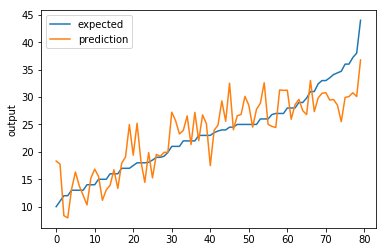

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

path = "./data/"
preprocess = False

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)


# Important Parameters

* **learning_rate** - How quickly should the optimizer attempt to train the neural network.  Too high will fail to train.  Too low will train too slowly.
* **momentum** - Only used with the momentum optimizer.  How much of the previous weight change direction should be used in the current step.
* **every_n_steps** - How often should the validation set be evaluated.
* **early_stopping_rounds** - How many rounds (steps) of non-improvement should be tolerated.

# Some results
* **ADAM**, learning_rate = 1e-1, early_stopping = 100
    * Score (RMSE): 3.5879969596862793
    * Best step: 1505, Last successful step: 1640
* **ADAM**, learning_rate = 1e-3, early_stopping = 100
    * Score (RMSE): 2.4205124378204346
    * Best step: 4650, Last successful step: 4770
* **ADAM**, default learning rate, early_stopping = 1000
    * Score (RMSE): 2.410527467727661
    * Best step: 6630, Last successful step: 7720
* **Momentum**, learning_rate=1e-5,momentum=0.9, early_stopping = 1000
    * Score (RMSE): 2.4050464630126953
    * Best step: 41270, Last successful step: 42280

ADAM will converge quicker (fewer steps) than momentum and get a good RMSE.  For all, it is important to allow enough early_stopping steps to find a good solution.

# Module 6 Assignment

You can find the first assignmeht here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class1.ipynb)